In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls

Installing packages:
	.package(path: "/home/jupyter/git/fastai_docs/dev_swift/FastaiNotebook_10_mixup_ls")
		FastaiNotebook_10_mixup_ls
With SwiftPM flags: []
Working in: /tmp/tmpo53sq9ns/swift-install
/home/jupyter/swift/usr/bin/swift-build: /home/jupyter/anaconda3/envs/swift/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/lib/swift/linux/libFoundation.so)
/home/jupyter/swift/usr/bin/swiftc: /home/jupyter/anaconda3/envs/swift/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swiftc)
Compile Swift Module 'FastaiNotebook_10_mixup_ls' (15 sources)
/home/jupyter/swift/usr/bin/swiftc: /home/jupyter/anaconda3/envs/swift/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swiftc)

/home/jupyter/swift/usr/bin/swift: /home/jupyter/anaconda3/envs/swift/lib/libuuid.so.1: no version information available (required by /home/jupyter/swift/usr/bin/swift)

/home/jupyter/swift/usr/

In [ ]:
import Foundation
import TensorFlow
import FastaiNotebook_10_mixup_ls
import Path

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Loading the data

Luckily, TensorFlow has a "decodeWav" function. Let's extend the StringTensor to provide swifty access to this function, the same way we did with JPGs.

In [ ]:
public extension StringTensor {
    // Decode a StringTensor holding a path to a WAV file into (audio: Tensor<Float>, sampleRate: Tensor<Int32>)
    func decodeWav() -> (audio: Tensor<Float>, sampleRate: Tensor<Int32>) {
        return Raw.decodeWav(contents: self)
    }
}

In [ ]:
let wav_file = "m0005_us_m0005_00445.wav"

In [ ]:
let (sig, sr) = StringTensor(readFile: wav_file).decodeWav()

### To Spectrogram

In [ ]:
let spec = Raw.audioSpectrogram(sig, 
                                windowSize: 1024, stride: 256, magnitudeSquared: false)

In [ ]:
func showSpec(s: Tensor<Float>) {
    plt.imshow(s.makeNumpyArray()[0], cmap: "plasma")
    plt.show()
    print("Shape: \(s.shape)\nMin:\(s.min()), max: \(s.max()), mean: \(s.mean()), var: \(s.variance())")
}

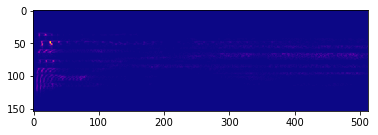

Shape: TensorShape(dimensions: [1, 154, 513])
Min:4.9222303e-06, max: 24.352493, mean: 0.12011659, var: 0.1986352


In [ ]:
showSpec(s: spec)

### To MFCCs

Note that MFCCs are different from melspectrograms. It seems TF doesn't have a melspectrogram transform built-in. MFCCs at least have been used before so it doesn't seem crazy to use them instead, although they are generally used to intentionally reduce the dimensionality of the data, so we might be throwing away info that the NN could use. On the other hand we might be making it easier for the NN to find features it would've had to spend time finding itself. We'll give it a shot. On the plus side, it means much "smaller images".

[TF defaults](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/ops/audio_ops.cc#L147) for MFCCs:
```
    .Attr("upper_frequency_limit: float = 4000")
    .Attr("lower_frequency_limit: float = 20")
    .Attr("filterbank_channel_count: int = 40")
    .Attr("dct_coefficient_count: int = 13")
```

In [ ]:
let mfccs = Raw.mfcc(spectrogram: spec, sampleRate: sr, 
                       upperFrequencyLimit: 8000, lowerFrequencyLimit: 20, 
                       filterbankChannelCount: 40, dctCoefficientCount: 13)

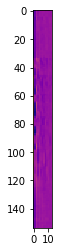

Shape: TensorShape(dimensions: [1, 154, 13])
Min:-7.5308914, max: 15.715063, mean: 0.08064073, var: 6.4020457


In [ ]:
showSpec(s: mfccs)